In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
import seaborn as sns
iris = sns.load_dataset('iris')

data = torch.tensor( iris[iris.columns[0:4]].values ).float()

labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [12]:
class ANNiris(nn.Module):

    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create dictionary to store layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        # input layer
        self.layers['input'] = nn.Linear(4, nUnits)

        # hidden layers
        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

        self.layers['output'] = nn.Linear(nUnits, 3)
    
    def forward(self, x):

        x = self.layers['input'](x)

        for i in range(self.nLayers):
            x = F.relu( self.layers[f'hidden{i}'](x) )
        
        x = self.layers['output'](x)
        return x

In [13]:
nUnitsPerLayers = 12
nLayers = 4

net = ANNiris(nUnitsPerLayers, nLayers)
net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [14]:
# quick test

tmpx = torch.rand(10, 4)

y = net(tmpx)

print(y.shape, end='\n')
print(y)

torch.Size([10, 3])
tensor([[ 0.1209, -0.1102, -0.2977],
        [ 0.1219, -0.1100, -0.2981],
        [ 0.1241, -0.1055, -0.2975],
        [ 0.1281, -0.1061, -0.2996],
        [ 0.1195, -0.1082, -0.2954],
        [ 0.1207, -0.1076, -0.2964],
        [ 0.1236, -0.1065, -0.2955],
        [ 0.1261, -0.1052, -0.2973],
        [ 0.1227, -0.1058, -0.2963],
        [ 0.1227, -0.1072, -0.2956]], grad_fn=<AddmmBackward0>)


In [15]:
# a function to train the model

def trainTheModel(theModel):
  
  # define the loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=.01)

  # loop over epochs
  for epochi in range(numepochs):

      # forward pass
      yHat = theModel(data)

      # compute loss
      loss = lossfun(yHat,labels)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  
  
  # final forward pass to get accuracy
  predictions = theModel(data)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels).float())

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

  # function outputs
  return acc,nParams

In [16]:
# test the function once

numepochs = 2500
acc = trainTheModel(net)

# check the outputs 
acc # tuple containing (accuracy,nparams)

(tensor(96.6667), 723)

In [ ]:
# this cell takes ~2 mins

# define the model parameters
numlayers = range(1,6)         # number of hidden layers
numunits  = np.arange(4,101,3) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))

# number of training epochs
numepochs = 500

# start the experiment!
i = 0
for unitidx in range(len(numunits)):
    i+=1
    print(i)
    for layeridx in range(len(numlayers)):
        # create a fresh model instance
        net = ANNiris(numunits[unitidx],numlayers[layeridx])

        # run the model and store the results
        acc,nParams = trainTheModel(net)
        accuracies[unitidx,layeridx] = acc

        # store the total number of parameters in the model
        totalparams[unitidx,layeridx] = nParams


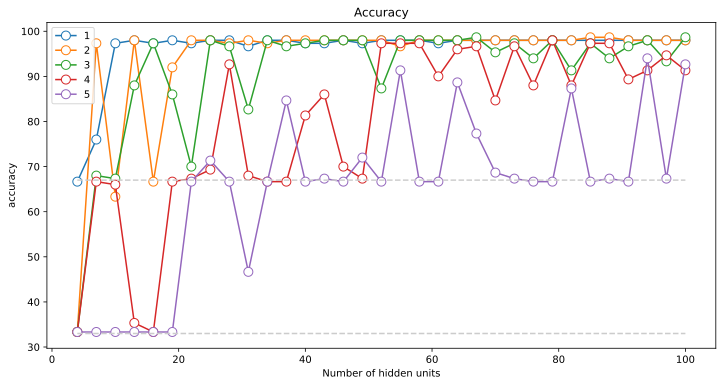

In [23]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(numunits,accuracies,'o-',markerfacecolor='w',markersize=9)
ax.plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

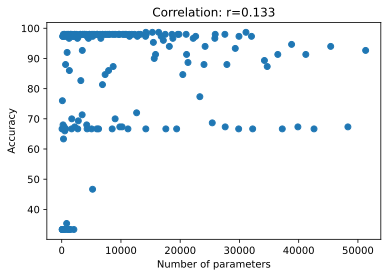

In [24]:
# Maybe it's simply a matter of more parameters -> better performance?

# vectorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()